In [1]:
import timeit

import numpy as np
import matplotlib.pyplot as plt

from scripts.queso_model import model_data, model_vars, objective_func, balance, alloc_df

# Enfriamiento Simulado

## Parámetros

In [2]:
# ¿Cómo se obtienen estas variables desde el sistema de información?

# Carpeta con los datos
folder = './data/test1/'
# Datos de centros de acopio
info_acopios = 'nuevo_info_acopios.xlsx'
# Matriz de costos de transporte entre CA
costo_transporte = 'costoTransporteCAi.xlsx'
# Matriz de tiempos de transporte entre CA
tiempo_transporte = 'tiempoTransporteCAi.xlsx'
# Demanda del cliente
demanda = 60
# Costo por unidad de tiempo
ctiempo = 100

folder = './data/test2/'
info_acopios = 'centros_acopio.xlsx'
costo_transporte = 'costo_transporte.xlsx'
tiempo_transporte = 'tiempos_transporte.xlsx'
demanda = 1400

# Temperatura inicial
max_anneal = 1e4
# Temperatura final de enfriamiento (terminación)
min_anneal = 1e-9
# Energía mínima (terminación)
energy = 1e-6
# Ratio de enfriamiento
r_anneal = 0.995

In [3]:
archivos = {
    'info_acopios': info_acopios,
    'costo_transporte' : costo_transporte,
    'tiempo_transporte' : tiempo_transporte,
}

data = model_data(archivos, demanda, ctiempo, folder=folder)

demanda = data['demanda']
ctiempo = data['ctiempo']
# t_max = data['t_max']
params_df = data['params_df']

N, seed, capacidades = model_vars(params_df)

## Generación
De nuevas posibles soluciones

In [4]:
# Generador del estado inicial
def gen_s0(n_vars):
    # Se indexan los centros de acopio
    gen_vector = np.zeros(n_vars+1, dtype=float)

    # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
    indices = np.arange(n_vars)
    np.random.shuffle(indices)

    while np.sum(gen_vector) < demanda and indices.size > 0:
        idx = indices[0]
        gen_vector[idx] += capacidades[idx]
        indices = np.delete(indices, 0)

        if np.sum(gen_vector) > demanda:
            gen_vector[idx] = gen_vector[idx] - (np.sum(gen_vector) - demanda)
            break

    gen_vector[n_vars] = np.random.randint(capacidades[n_vars] + 1)

    return gen_vector

In [5]:
# def gen_s(self, problem, X):
#     for i in range(len(X)):
#         r = np.random.random()
# 
#         if r < self.prob:
#             # Se toma un índice aleatorio
#             individual = X[i]
#             idx_mut = np.random.randint(individual.shape)
# 
#             # Si es el índice del centro de acopio principal (N*2)
#             if idx_mut == N*2:
#                 X[i, problem.n_var-1] = np.random.randint(CAPACIDADES[N*2] + 1)
# 
#             else:
#                 if individual[idx_mut] == 0:
#                     # Se asigna la máxima cantidad posible del índice
#                     delta = CAPACIDADES[idx_mut]
#                     individual[idx_mut] = CAPACIDADES[idx_mut]
#                     diff = True
#                 else:
#                     # Se asigna cero a la cantidad del índice
#                     delta = individual[idx_mut]
#                     individual[idx_mut] = 0
#                     diff = False
# 
#                 balance(individual, delta, diff)
# 
#                 for j in range(individual.shape[0]):
#                     X[i, j] = individual[j]
# 
#     return X

Pseudocódigo del método de enfriamiento simulado implementado:

$$
\textit{Sea } s = s_0 \\ 
\textit{Mientras } t > t_{min}, e > e_{th}: \\
\qquad \text{Generar una nueva solución aleatoria, } s_{new} \leftarrow genS(s) \\ 
\qquad \textit{Si } f(s) > f(s_{new}): \\
\qquad \qquad \textit{entonces } s \leftarrow s_{new} \\
\qquad \textit{Sino:} \\
\qquad \qquad \textit{Si } P(f(s), f(s_{new}), t) \geq rand(0, 1): \\ 
\qquad \qquad \qquad \textit{entonces } s \leftarrow s_{new} \\
\text{Salida: } s_{final}
$$

In [6]:
def anneal(t, t_min, e_th, alpha):
    size = capacidades.shape[0] - 1
    # Función objetivo
    f = objective_func
    # Estado inicial (s0)
    s = gen_s0(N*2)
    # función objetivo a minimizar (a.k.a energía, fitness)
    e = f(s, N, data)
    # Contador de iteraciones o pasos
    k = 0

    while t > t_min and e > e_th:
        s_new = gen_s0(size)
        e_new = f(s_new, N, data)

        delta = e_new - e

        if delta < 0:
            s = s_new
            e = e_new
        else:
            asd = -delta / t
            p = np.exp(asd)
            r = np.random.rand()

            if r < p:
                s = s_new
                e = e_new

        t *= alpha
        k += 1

    return s, k


def sa(t_max, t_min, e_th, alpha, key=1):
    np.random.seed(key)
    x, count = anneal(t_max, t_min, e_th, alpha)
    print(f'Count: ', count)
    return x


## Aplicación

In [7]:
t_start_sa = timeit.default_timer()
sa = sa(max_anneal, min_anneal, energy, r_anneal)
t_end_sa = timeit.default_timer()

t_delta_sa = t_end_sa - t_start_sa

Count:  5972


In [8]:
print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(sa[N*2])]}')
print(f'Precio: {objective_func(sa, N, data)}')
print(f'Tiempo: {round(t_delta_sa * 1000)}ms, ({t_delta_sa})')

Centro de acopio principal: CA8
Precio: 28801039.961266886
Tiempo: 1465ms, (1.4647080000031565)


In [9]:
asignaciones = alloc_df(sa, params_df, N, capacidades)
asignaciones.head()

,index,CAcopio,Capacidad,Asignada
0,0,CA1 Stock,1256.0,1177.0
1,1,CA1 Potencial,223.0,223.0
2,2,CA2 Stock,1830.0,0.0
3,3,CA2 Potencial,242.0,0.0
4,4,CA3 Stock,1350.0,0.0


## Resultados

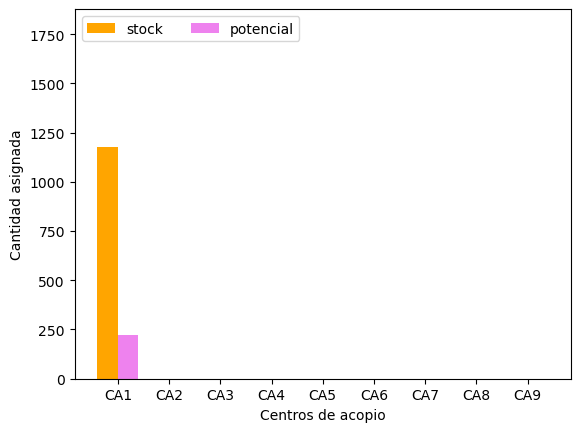

In [10]:
even = np.arange(0, N*2-1, 2)
odd = np.arange(1, N*2, 2)

cap_stock = np.take(capacidades, even)
cap_potencial = np.take(capacidades, odd)

ca_stock = np.take(sa, even)
ca_potencial = np.take(sa, odd)
    
labels = params_df['Id_CA']
x = np.arange(len(labels))
y1 = ca_stock
y2 = ca_potencial

fig, ax = plt.subplots()
y_lim = np.array(np.mean([np.max(capacidades), np.max(sa)])) * 1.1
ax.set_ylim([0, y_lim])
x1_bar = ax.bar(x-0.2, y1, width=0.4, label='stock', color='orange')
x2_bar = ax.bar(x+0.2, y2, width=0.4, label='potencial', color='violet')

plt.xticks(x, labels)
plt.xlabel('Centros de acopio')
plt.ylabel('Cantidad asignada')
plt.legend(loc='upper left', ncol=2)
plt.show()

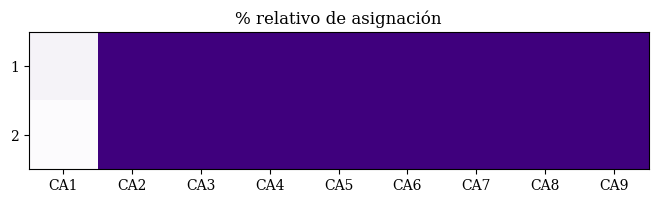

In [11]:
from pymoo.visualization.heatmap import Heatmap

ca_stock_norm = ca_stock / cap_stock
ca_potencial_norm = ca_potencial / cap_potencial
ca_heatmap = np.vstack((ca_stock_norm, ca_potencial_norm))

heatmap = Heatmap(bounds=(0, 1),
                  title='% relativo de asignación',
                  cmap='Purples',
                  labels=labels.values.tolist(),
                  y_labels=['Stock', 'Potencial'])
heatmap.add(ca_heatmap)
heatmap.show()

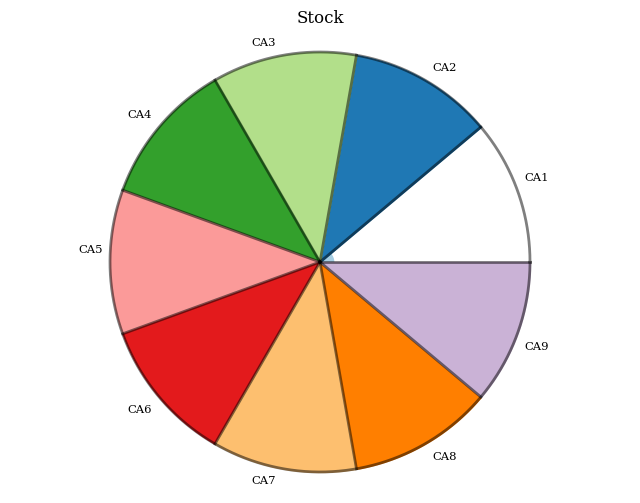

In [12]:
from pymoo.visualization.petal import Petal
# add both petals in a single graph?
petal = Petal(bounds=(0, 1),
              cmap='Paired',
              title='Stock',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_stock_norm)
petal.show()

In [13]:
petal = Petal(bounds=(0, 1),
              cmap='Set3_r',
              title='Potencial',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_potencial_norm)
# petal.show()

# todo

Comenzar a buscar parámetros óptimos y documentar los resultados (La solución es óptima?) 

Hacer varias ejecuciones y medir estadísticos sobre los resultados obtenidos (varianza)